# STL and ARIMA

In [367]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import plotly.express as px
from sklearn.utils import resample  # For bootstrapping
import numpy as np
#from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA


## Load data

In [368]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1571,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False
1572,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False
1573,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False
1574,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False


## STL and ARIMA

In [369]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 129
Outlier cases: 119


In [370]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [371]:
# Set Outlier values to missing
df.loc[df['Outlier'], 'Revenue Losses'] = None

# While loop to fill with 7 day lags
# Alternate between computing 7 day lags
# and filling missing values with 7 day lags
while df['Revenue Losses'].isnull().sum() > 0:
    # Compute 7 day lags
    df['7-day lag'] = df['Revenue Losses'].shift(7)
    # Fill missing values with 7 day lags
    df['Revenue Losses'] = df['Revenue Losses'].fillna(df['7-day lag'])

In [372]:
# Revenue Losses
fig = px.line(df, x='Date', y='Revenue Losses',
              title='Revenue Losses From Broken Machines ($625 per day per machine)',
              labels={'Revenue Losses': 'Revenue Losses'},
              line_shape='linear')

# Center title
fig.update_layout(title_x=0.5)

# Dollar format
fig.update_layout(yaxis_tickprefix='$')

# Show the plot
fig.show()

In [373]:
# For this model, limit data to last year
# This will both take care of outliers and minimize missing data
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=1)].reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train,Missing,7-day lag
0,2024-02-16,241.0,3974.0,6.064419,1012500.0,True,True,False,1012500.0
1,2024-02-17,1511.0,15466.0,9.769818,944375.0,False,True,False,950625.0
2,2024-02-18,1816.0,15880.0,11.435768,1135000.0,False,True,False,1088125.0
3,2024-02-19,2004.0,15851.0,12.642735,1252500.0,False,True,False,1136875.0
4,2024-02-20,1908.0,15908.0,11.993965,1192500.0,False,True,False,1083125.0
...,...,...,...,...,...,...,...,...,...
362,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False,False,773125.0
363,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False,False,736875.0
364,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False,False,679375.0
365,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False,False,694375.0


In [374]:
# Count missing and outlier cases
print('Missing cases:', df['Missing'].sum())
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 35


In [375]:
df = df[['Date', 'Revenue Losses', 'Train']]
df

,Date,Revenue Losses,Train
0,2024-02-16,1012500.0,True
1,2024-02-17,944375.0,True
2,2024-02-18,1135000.0,True
3,2024-02-19,1252500.0,True
4,2024-02-20,1192500.0,True
...,...,...,...
362,2025-02-12,798125.0,False
363,2025-02-13,743125.0,False
364,2025-02-14,667500.0,False
365,2025-02-15,691875.0,False


In [376]:
# Train/test split
train_df = df.query('Train == 1').reset_index(drop=True)
test_df = df.query('Train == 0').reset_index(drop=True)
print(len(train_df), len(test_df))

337 30


Lambda: 1.0007432108845746


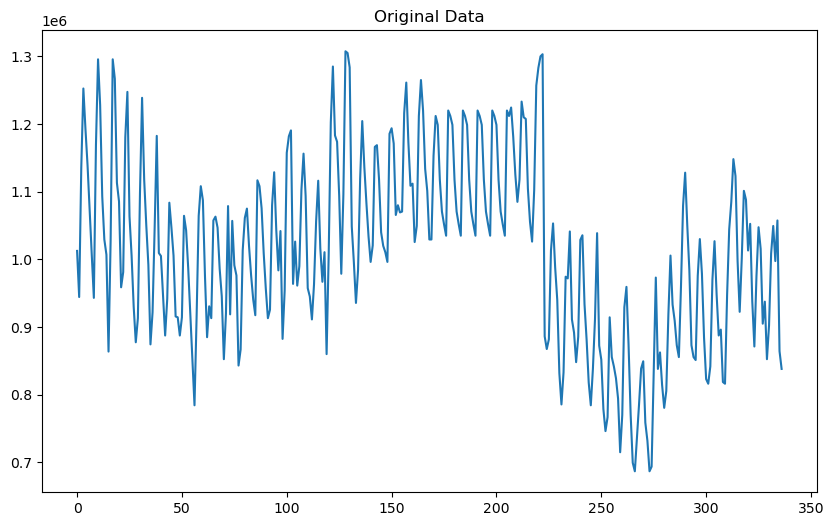

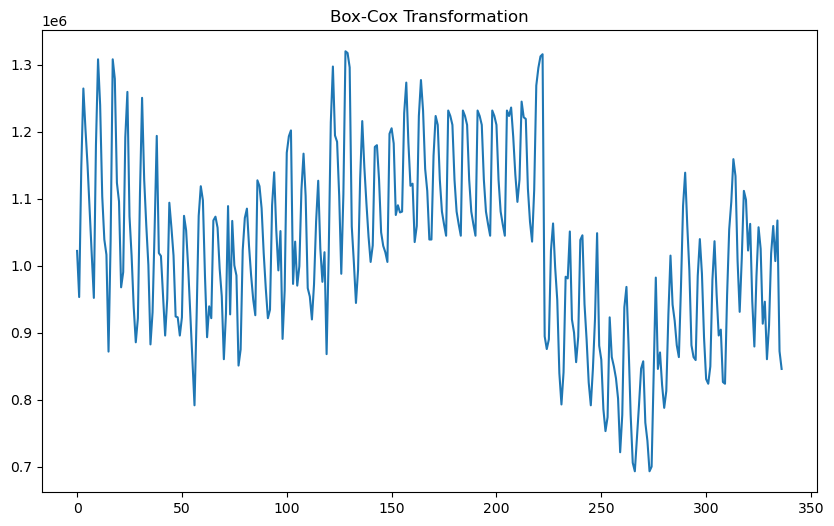

In [377]:
# Box-Cox transformation
y_transformed, lam = stats.boxcox(train_df['Revenue Losses'])
print('Lambda:', lam)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(train_df['Revenue Losses'])
plt.title('Original Data')
plt.show()

# Plot the transformed data
plt.figure(figsize=(10, 6))
plt.plot(y_transformed)
plt.title('Box-Cox Transformation')
plt.show() # Does not change anything, variance, roughly constant anyway

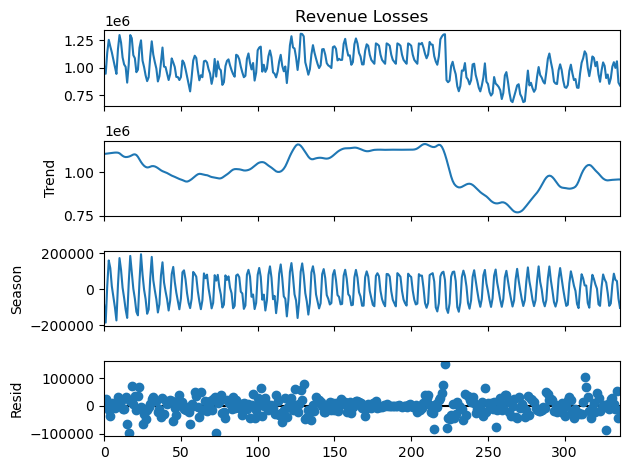

In [378]:
# 1. STL Decomposition
decomposition = STL(train_df['Revenue Losses'], period=7).fit()
seasonally_adjusted = decomposition.resid

# Plot the Decomposition Components
decomposition.plot()  # Plots original, trend, seasonal, and residual
plt.show()

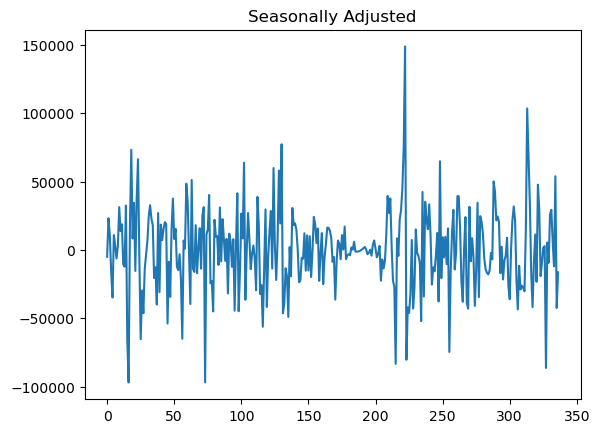

In [379]:
# Line plot of the residuals
plt.plot(seasonally_adjusted)
plt.title('Seasonally Adjusted')
plt.show()

In [380]:
# 2. auto_arima on Seasonally Adjusted Data
auto_model = auto_arima(seasonally_adjusted, seasonal=False,  # Important: seasonal=False
                        stepwise=True, trace=True,
                        suppress_warnings=True, error_action='ignore')
best_order = auto_model.order  # Get the best (p, d, q) order
print('optimal order: ', best_order)

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7898.718, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7895.901, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7895.712, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7897.710, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7897.776, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7897.714, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.590 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [381]:
# 3. STLForecast with the Determined Order
stlf = STLForecast(train_df['Revenue Losses'], ARIMA, model_kwargs={"order": best_order}, period=7) # Use the found order
stlf_fitted = stlf.fit()

stlf_fitted_values = stlf_fitted.get_prediction().predicted_mean #+ decomposition.trend + decomposition.seasonal
stlf_residuals = train_df['Revenue Losses'] - stlf_fitted_values

# Get forecast
test_forecast = stlf_fitted.forecast(30)

In [382]:
# Check residuals
def plot_stlforecast_residuals(fv, resids, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for STLForecast.

    Args:
        fit: The fitted STLForecast model object (result of fit()).
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    fitted_values = fv
    residuals = resids

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')  # Or time index
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    fig.delaxes(axes[2,1]) # Remove the unnecessary subplot

    plt.tight_layout()
    plt.show()

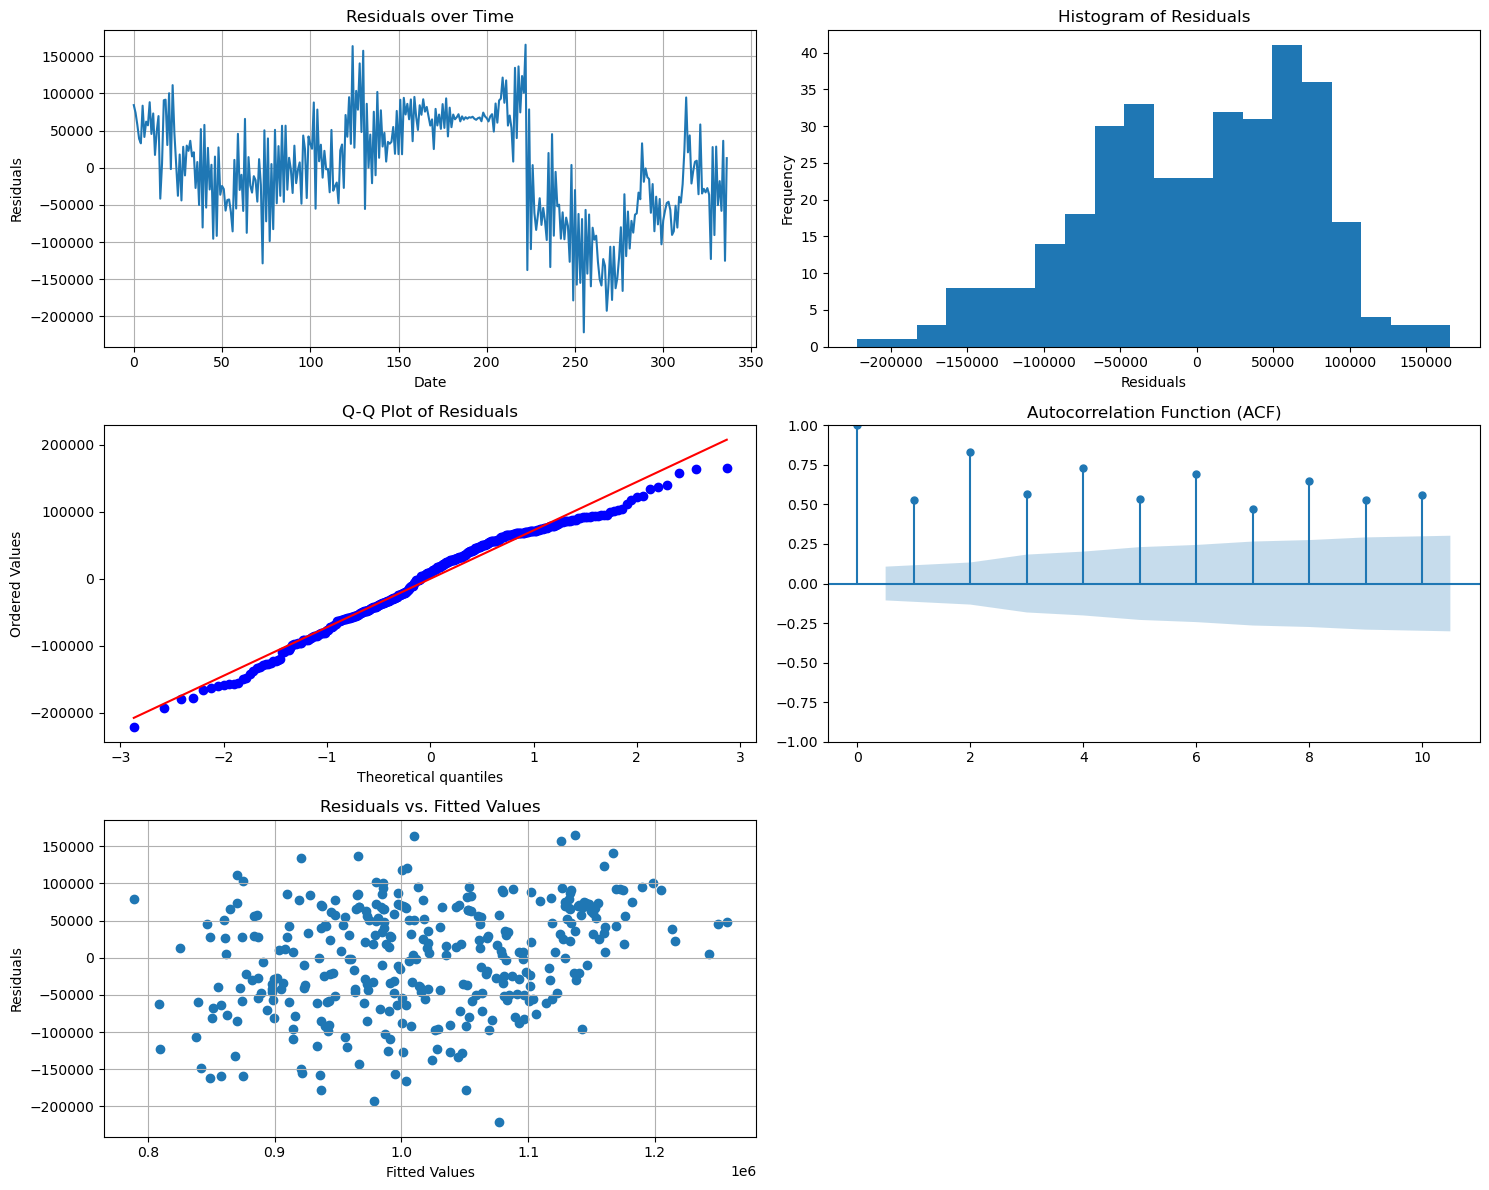

In [383]:
plot_stlforecast_residuals(stlf_fitted_values, stlf_residuals)

In [384]:
# 1. Get Residuals from the Training Data
train_residuals = stlf_residuals

# 2. Bootstrapping Function
def bootstrap_forecast(train_data, train_residuals, test_len, n_bootstraps=500):
    forecasts = []
    for _ in range(n_bootstraps):
        # 2a. Resample Residuals with Replacement
        resampled_residuals = list(resample(train_residuals, replace=True))

        # 2b. Create "Bootstrapped" Training Data
        bootstrapped_train = train_data + resampled_residuals

        # Forecasting steps:

        # 1. STL Decomposition
        boot_decomposition = STL(bootstrapped_train, period=7).fit()
        boot_seasonally_adjusted = boot_decomposition.resid

        # 2. auto_arima on Seasonally Adjusted Data
        boot_auto_model = auto_arima(boot_seasonally_adjusted, seasonal=False,  # Important: seasonal=False
                                stepwise=True, trace=True,
                                suppress_warnings=True, error_action='ignore')
        boot_best_order = boot_auto_model.order  # Get the best (p, d, q) order
        print('optimal order: ', boot_best_order)

        # 3. STLForecast with the Determined Order
        boot_stlf = STLForecast(bootstrapped_train, ARIMA, model_kwargs={"order": best_order}, period=7)
        boot_stlf_fitted = boot_stlf.fit()

        # Get forecast
        boot_forecast = boot_stlf_fitted.forecast(test_len)
        forecasts.append(boot_forecast)

    return np.array(forecasts)  # Return as a NumPy array for easier manipulation

# 3. Generate Bootstrapped Forecasts
n_bootstraps = 500  # Number of bootstrap iterations (adjust as needed)
boot_forecasts = bootstrap_forecast(train_df['Revenue Losses'], stlf_residuals, len(test_df), n_bootstraps)

# 4. Calculate Prediction Intervals
alpha = 0.05  # Significance level (for 95% interval)
lower_bounds = np.percentile(boot_forecasts, (alpha / 2) * 100, axis=0)  # Lower percentile
upper_bounds = np.percentile(boot_forecasts, (1 - alpha / 2) * 100, axis=0)  # Upper percentile

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8379.462, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8371.404, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8363.840, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8365.846, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.555 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8353.946, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8355.388, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8354.761, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8355.946, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.409 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8417.380, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8410.923, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8405.467, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8407.479, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.534 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8380.671, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8377.956, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8374.714, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8376.713, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.470 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8421.717, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8416.947, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8412.077, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8414.080, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.532 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8353.279, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8350.244, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8346.171, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8348.177, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.601 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8366.939, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8363.094, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8354.942, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8356.943, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.514 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8401.830, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8392.053, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8387.365, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8389.365, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.520 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8417.390, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8418.070, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8417.449, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8419.389, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8387.561, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8386.415, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8384.126, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8386.132, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.553 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8417.786, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8413.232, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8411.737, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8409.236, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8411.227, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.737 seconds
optimal order:  (0, 0, 2)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8308.466, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8303.855, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8302.028, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8304.028, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.717 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8322.283, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8321.959, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8320.927, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8322.927, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.563 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8369.233, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8368.516, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8367.127, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8369.127, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.584 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8338.380, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8334.455, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8333.424, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8335.425, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.580 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8370.105, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8370.596, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8370.225, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8372.105, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.398 seconds
optimal order:  (0, 0, 0)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8391.623, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8389.425, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8384.395, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8386.398, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.501 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8382.870, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8379.285, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8378.224, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8375.504, Time=0.05 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8377.510, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.914 seconds
optimal order:  (0, 0, 2)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8359.495, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8352.762, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8352.025, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8354.008, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.620 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8360.562, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8359.316, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8357.686, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8359.684, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.500 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8367.737, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8360.905, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8359.360, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8357.727, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8359.726, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.838 seconds
optimal order:  (0, 0, 2)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8343.968, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8339.684, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8336.392, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8338.388, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.571 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8416.635, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8411.619, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8407.620, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8409.621, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.550 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8352.595, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8353.106, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8352.177, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8354.176, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.569 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8368.770, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8361.955, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8356.113, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8358.117, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.607 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8406.059, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8398.706, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8391.290, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8393.289, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.548 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8325.188, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8324.329, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8322.212, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8303.380, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8305.320, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.911 seconds
optimal order:  (0, 0, 2)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8410.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8410.154, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8408.487, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8410.487, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.608 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8404.730, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8405.070, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8404.379, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8406.387, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.704 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8366.278, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8361.580, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8355.175, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8357.179, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.583 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8422.361, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8419.460, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8417.873, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8419.879, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.702 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8365.055, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8364.543, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8363.703, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8365.696, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.615 seconds
optimal order:  (0, 0, 1)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8420.445, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8416.799, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8415.082, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8410.203, Time=0.03 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8412.202, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.917 seconds
optimal order:  (0, 0, 2)
Performing stepwise search to minimize aic


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8388.388, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8380.060, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8372.924, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8374.928, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.614 seconds
optimal order:  (0, 0, 1)


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8388.168, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8383.920, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8381.740, Time=0.04 sec


c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



KeyboardInterrupt: 

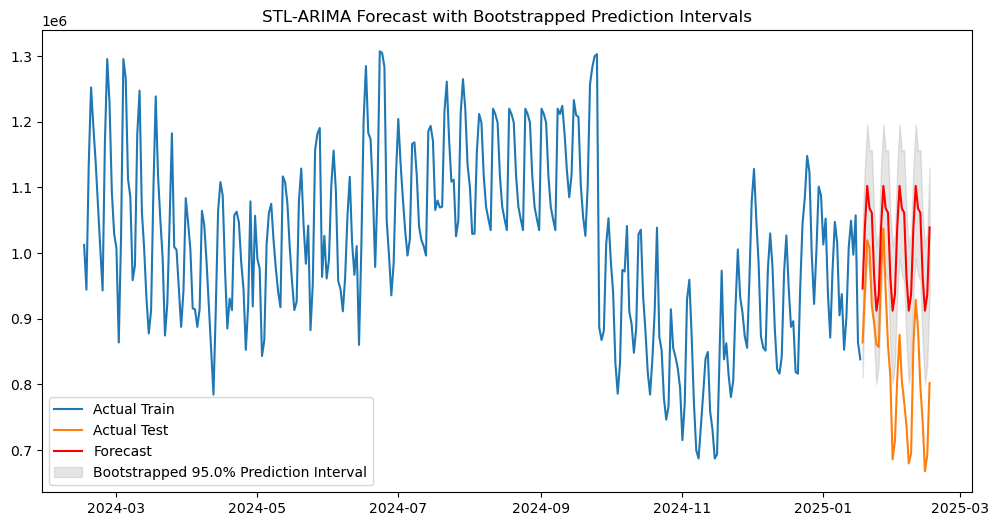

In [ ]:
# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Revenue Losses'], label='Actual Train')
plt.plot(test_df['Date'], test_df['Revenue Losses'], label='Actual Test')
plt.plot(test_df['Date'], test_forecast, label='Forecast', color='red')  # Original forecast

plt.fill_between(test_df['Date'], lower_bounds, upper_bounds, color='gray', alpha=0.2, label=f'Bootstrapped {100*(1-alpha)}% Prediction Interval')

plt.title('STL-ARIMA Forecast with Bootstrapped Prediction Intervals')
plt.legend()
plt.show()

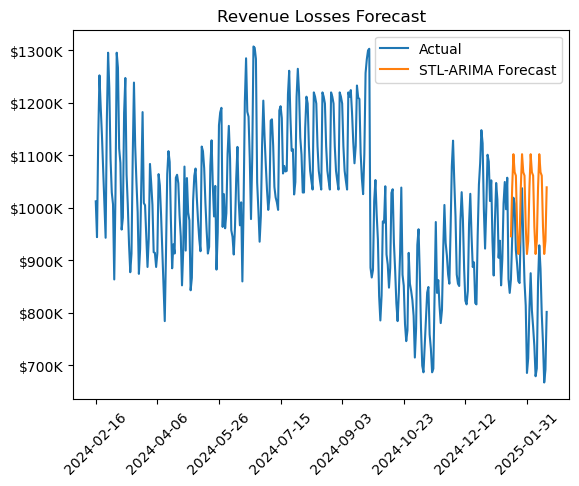

MAE: 173157.38192619724
RMSE: 188371.0876772521


In [ ]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="STL-ARIMA Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE, RMSE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
rmse = root_mean_squared_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)
print('RMSE:', rmse)

Not very good.